# **Previsão de diabetes**
Por : Pedro H. Velame

# **Dicionário de dados.**



---

**Pregnancies**	     Para expressar o número de gestações

**Glucose**	         Para expressar o nível de glicose no sangue

**BloodPressure**	   Para expressar a medição da pressão arterial

**SkinThickness**	   Para expressar a espessura da pele

**Insulin**	         Para expressar o nível de insulina no sangue

**BMI**	             Para expressar o índice de massa corporal

**DiabetesPedigreeFunction**	Para expressar a porcentagem de Diabetes

**Age**	Para expressar a idade

**Outcome**	Para expressar o resultado final 1 é Sim e 0 é Não


# Sobre o dataset

**Sobre o conjunto de dados**

---
Este conjunto de dados é originalmente do National Institute of Diabetes and Digestive and Kidney
Doenças. O objetivo do conjunto de dados é prever de forma diagnóstica se um paciente tem diabetes,
com base em certas medições de diagnóstico incluídas no conjunto de dados. Várias restrições foram colocadas
na seleção dessas instâncias de um banco de dados maior. Em particular, todos os pacientes aqui são mulheres
pelo menos 21 anos de herança indígena Pima.2
Do conjunto de dados no arquivo (.csv) podemos encontrar diversas variáveis, algumas delas são independentes
(várias variáveis ​​preditoras médicas) e apenas uma variável alvo dependente (Outcome)**


---


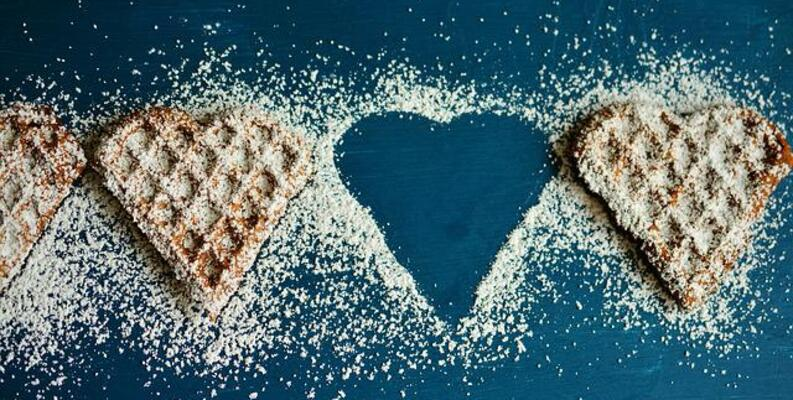



# Instalação da biblioteca de automl MLJAR.

In [ ]:
!pip install mljar-supervised

# Importação das bibliotecas.

In [ ]:
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from imblearn.combine import SMOTETomek 
from collections import Counter
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from supervised.automl import AutoML

import warnings

warnings.filterwarnings("ignore")

# Carregamento dos dados.

In [ ]:
df = pd.read_csv('/content/diabetes.csv')

In [ ]:
df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**Podemos perceber que temos valores anormais como o da insulina que está 0, assim como o da SkinThickness, não são valores normais para uma pessoa viva,há algo de errado nesses valores, portanto, requer pré-processamento, transformarei primeiramente em valores nulos ( 0 para null) para após aplicar algum método de substituição.**

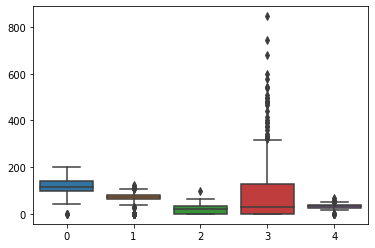

In [ ]:
columns_1 = [df.Glucose,df.BloodPressure,df.SkinThickness,df.Insulin,df.BMI]

sns.boxplot(data = columns_1)

**Podemos também notar que temos muitos outliers na coluna de insulina**

# Preprocessamento (substituição de valores 0 por nulos,a partir daí apliquei o método de imputer K-ésimo Vizinho mais Próximo(KNN).

In [ ]:
cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

#Substituição dos valores 0 para nulos(nan) para as colunas "Glucose", "BloodPressure", "SkinThickness", "Insulin" e "BMI".
df[cols] = df[cols].replace(['0', 0], np.nan)

In [ ]:
#Aplicação do método de imputer KNN
imputer = KNNImputer(missing_values=np.nan)

#O método retorna um array numpy
imputer.fit_transform(df)

array([[  6.   , 148.   ,  72.   , ...,   0.627,  50.   ,   1.   ],
       [  1.   ,  85.   ,  66.   , ...,   0.351,  31.   ,   0.   ],
       [  8.   , 183.   ,  64.   , ...,   0.672,  32.   ,   1.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,   0.245,  30.   ,   0.   ],
       [  1.   , 126.   ,  60.   , ...,   0.349,  47.   ,   1.   ],
       [  1.   ,  93.   ,  70.   , ...,   0.315,  23.   ,   0.   ]])

In [ ]:
#Transformação do array numpy num dataframe pandas para uma melhor análise.
df = pd.DataFrame(imputer.fit_transform(df))

#Adicionando de volta os nomes das columnas que foram removidos, pois, o imputer transformou em array.
columns = ["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age","Outcome"]
df.columns = columns

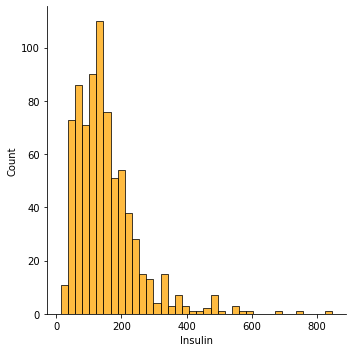

In [ ]:
sns.displot(df['Insulin'],color="orange")

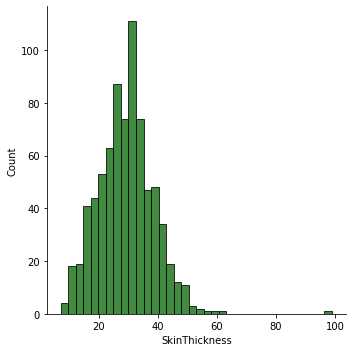

In [ ]:
sns.displot(df['SkinThickness'],color="darkgreen")

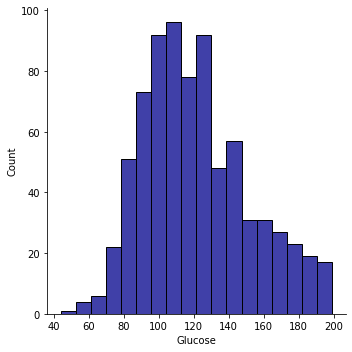

In [ ]:
sns.displot(df['Glucose'],color = "darkblue")

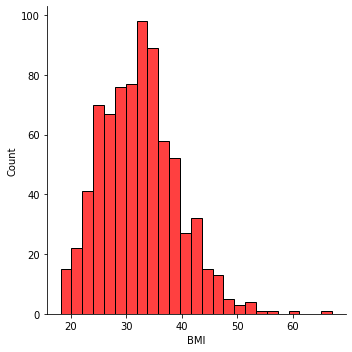

In [ ]:
sns.displot(df['BMI'],color = "red")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    float64
dtypes: float64(9)
memory usage: 54.1 KB


Substituir valores nulos pelas médias

# Análise de correlação entre variáveis.



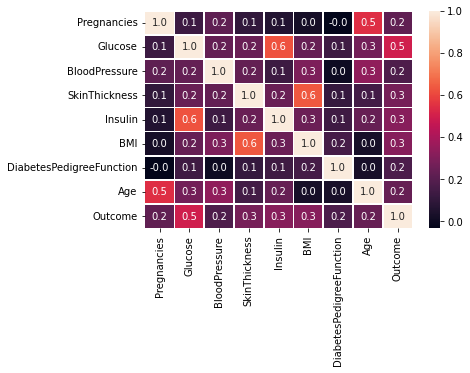

In [ ]:
#Na aplicação do método de correlação corr() pude perceber que algumas variáveis possui algum nível de correlação.
#Logo como alternativa transformei num mapa de calor para melhor visualização.

sns.heatmap(df.corr(), annot = True, fmt=".1f", linewidths=.6)

**A partir daí plotei as correlações que mais se destacaram e separei pela variável alvo, se terá diabetes(1) ou não terá(0)**

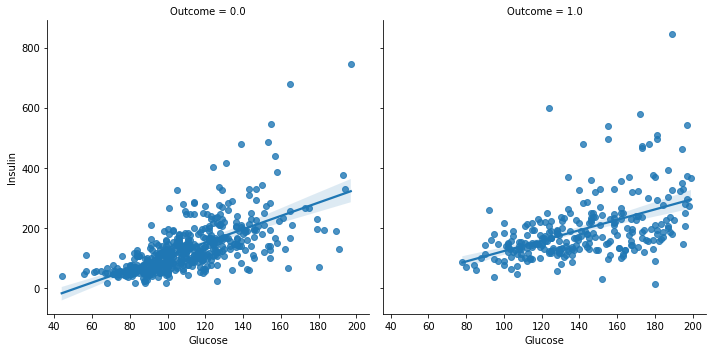

In [ ]:
reg = sns.lmplot(data=df, 
                 x = 'Glucose', 
                 y = 'Insulin',
                 col = 'Outcome',
                 legend = True,
                 fit_reg = True)

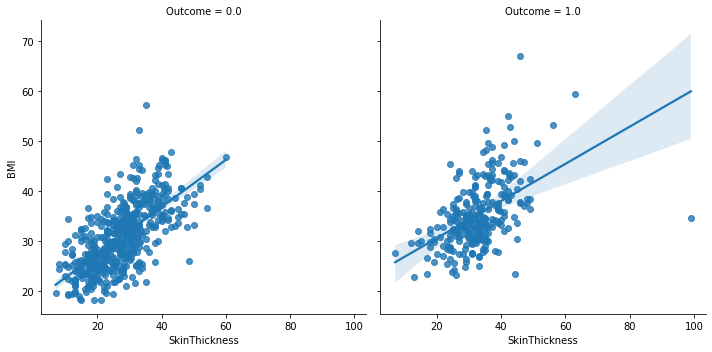

In [ ]:
reg = sns.lmplot(data=df, 
                 x = 'SkinThickness', 
                 y = 'BMI',
                 col = 'Outcome',
                 legend = True,
                 fit_reg = True)

# Separação e contagem das features e da variável alvo (X e y).
logo, percebe-se o desbalanceamento da variável alvo, o que requer um método de balanceamento, nesse caso, utilizei o SMOTETomek, que faz Over-sampling usando SMOTE e limpeza usando Tomek links.
Combina over e undersampling usando os links SMOTE e Tomek.


In [ ]:
X = df.drop(columns = 'Outcome')
y = df['Outcome']

Counter(y)

Counter({1.0: 268, 0.0: 500})

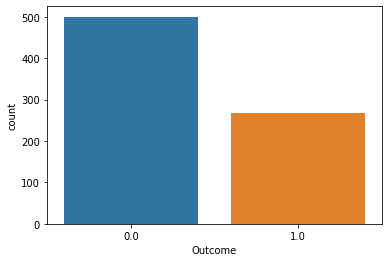

In [ ]:
sns.countplot(df['Outcome'])

In [ ]:
#Aplicação do método SMOTETomek
X_res, y_res = SMOTETomek().fit_resample(X, y)

print(Counter(y_res))

Counter({1.0: 479, 0.0: 479})


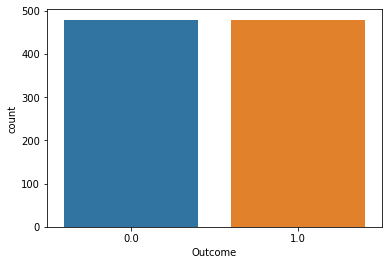

In [ ]:
sns.countplot(y_res)

# Separação dos dados em treino e teste utilizando os dados já balanceados.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20)

# Criação do modelo preditivo Ensemble RandomForestClassifier.

In [ ]:
model_ran_for = sklearn.ensemble.RandomForestClassifier(n_estimators=1000)

model_ran_for.fit(X_train,y_train)

model_ran_for.score(X_test,y_test)

pred_ran_for = model_ran_for.predict(X_test)

In [ ]:
print("Obtivemos a acurácida de:",metrics.accuracy_score(y_test, pred_ran_for))

Obtivemos a acurácida de: 0.8645833333333334


In [ ]:
pd.DataFrame(model_ran_for.predict_proba(X_test))

,0,1
0,0.588,0.412
1,0.237,0.763
2,0.236,0.764
3,0.378,0.622
4,0.315,0.685
...,...,...
187,0.880,0.120
188,0.775,0.225
189,0.887,0.113
190,0.514,0.486


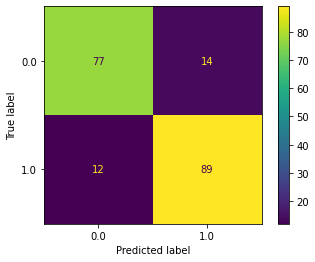

In [ ]:
plot_confusion_matrix(model_ran_for, X_test, y_test)

# Criação modelo Regressão logística para classificação binária.


In [ ]:
model_reg_log = LogisticRegression(fit_intercept=True)

model_reg_log.fit(X_train,y_train)

model_reg_log.score(X_test,y_test)

pred_reg_log = model_reg_log.predict(X_test)

In [ ]:
print("Obtivemos a acurácida de:",metrics.accuracy_score(y_test, pred_reg_log))

Obtivemos a acurácida de: 0.796875


In [ ]:
pd.DataFrame(model_reg_log.predict_proba(X_test))

,0,1
0,0.630029,0.369971
1,0.384957,0.615043
2,0.339114,0.660886
3,0.009712,0.990288
4,0.236863,0.763137
...,...,...
187,0.646535,0.353465
188,0.259981,0.740019
189,0.782410,0.217590
190,0.579211,0.420789


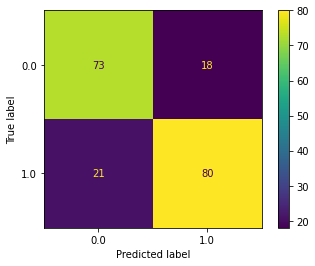

In [ ]:
plot_confusion_matrix(model_reg_log, X_test, y_test)


# Utilização do mljar-supervised AUTOML

O mljar-supervisioned é um pacote Python de aprendizado de máquina automatizado que funciona com dados tabulares. Ele é projetado para economizar tempo para um cientista de dados. Ele abstrai a maneira comum de pré-processar os dados, construir os modelos de aprendizado de máquina e realizar o ajuste de hiperparâmetros para encontrar o melhor modelo. Não é uma caixa preta, pois você pode ver exatamente como o pipeline de ML é construído (com um relatório Markdown detalhado para cada modelo de ML).


In [ ]:
automl = AutoML(mode="Explain")

automl.fit(X, y)

predictions = automl.predict(X)

AutoML directory: AutoML_12
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.646799 trained in 2.65 seconds
2_DecisionTree logloss 0.540568 trained in 20.46 seconds
3_Linear logloss 0.456441 trained in 4.0 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.494208 trained in 6.26 seconds
5_Default_NeuralNetwork logloss 0.532378 trained in 1.86 seconds
6_Default_RandomForest logloss 0.476718 trained in 7.73 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.446728 trained in 0.9 seconds
AutoML fit time: 58.04 seconds
AutoML best model: Ensemble


In [ ]:
print("Obtivemos a acurácia de:",metrics.accuracy_score(y, predictions))

Obtivemos a acurácia de: 0.7916666666666666


In [ ]:
pd.DataFrame(automl.predict_proba(X))

,0,1
0,0.296080,0.703920
1,0.969430,0.030570
2,0.196671,0.803329
3,0.969182,0.030818
4,0.148496,0.851504
...,...,...
763,0.790945,0.209055
764,0.641197,0.358803
765,0.787704,0.212296
766,0.611495,0.388505


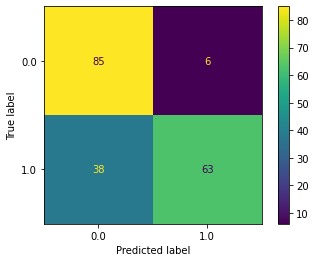

In [ ]:
plot_confusion_matrix(automl, X_test, y_test)  